<font size = "+1">2017-2018 Applied Mathematics Master's Project</font>

<b>Topic:</b> Classification of sEMG Hand Signals Using Machine Learning Methods

<b>Objective:</b> To process sEMG hand signals, extract out key features from both the time and frequency domains, and
classify these signals with machine learning models such as random forest and gradient boosting. Moreover, to
develop a framework which allows for plug-and-play feature extraction, model choice, and advanced data visualization. 

<b>Data decription:</b> There are two datasets used in this notebook. For one dataset, two males and three females of the same age approximately (20 to 22-year-old) conducted the six grasps for 30 times each. The measured time is 6 sec. For the other dataset, one male subject conducted the six grasps for 100 times each for 3 consecutive days. The measured time is 5 sec. 

<b>How the data was gathered:</b> Subjects were asked to perform these varies grasp movements while two electrodes were placed on their forearms to read the sEMG signals. The performed grasps were as follows: 'Spherical' for holding spherical tools, 'Tip' for holding small tools, 'Palmar' for grasping with palm facing the object, 'Lateral' for holding thin, flat objects, 'Cylindrical' for holding cylindrical tools and 'Hook' for supporting a heavy load.

A link to the datasets used in this notebook and a detailed decription of the data can be found at https://archive.ics.uci.edu/ml/datasets/sEMG+for+Basic+Hand+movements. This data was gathered and
submitted by Christos Sapsanis, Anthony Tzes, and G. Georgoulas. 

The following code loads the necessary libraries for the analysis.

In [3]:
# load modules

# generic libraries
import numpy as np
import itertools
import time
import random

# library for loading in matlab files
import scipy.io as sio

# loading data from web libraries
import requests
import io
import zipfile

# time series function from the statsmodels library
from statsmodels.tsa.ar_model import AR

# general machine learning functions from the sklearn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# machine learning model functions
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# dimensionality reduction functions
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# plotting library
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import find
import matplotlib.patches as mpatches

Next download hand data from the UCI Machine Learning Repository and place these datasets into your current working directory. 

In [4]:
# get hand data from web and put in your working directory
req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00313/sEMG_Basic_Hand_movements_upatras.zip")
z = zipfile.ZipFile(io.BytesIO(req.content))
z.extractall()

The code that follows contains all the functions used for this analysis--this includes loading data functions, feature extraction functions, classification functions and a visualization function. 

In [5]:
#######################################################################################################################
# loading functions

def load_hand_signals_five_subjects():
    '''
    This function loads data from Database 1 which contains
    all the sEMG signals for the experiment with five subjects.
    
    Import each subject's dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat(".\\Database 1\\female_1.mat")
    del signal_1['__header__'] # remove metadata
    del signal_1['__globals__']
    del signal_1['__version__']
    subject_signals.append(signal_1)
    signal_2 = sio.loadmat(".\\Database 1\\female_2.mat")
    del signal_2['__header__'] 
    del signal_2['__globals__']
    del signal_2['__version__']
    subject_signals.append(signal_2)
    signal_3 = sio.loadmat(".\\Database 1\\female_3.mat")
    del signal_3['__header__'] 
    del signal_3['__globals__']
    del signal_3['__version__']
    subject_signals.append(signal_3)

    signal_4 = sio.loadmat(".\Database 1\male_1.mat")
    del signal_4['__header__'] 
    del signal_4['__globals__']
    del signal_4['__version__']
    subject_signals.append(signal_4)
    signal_5 = sio.loadmat(".\Database 1\male_2.mat")
    del signal_5['__header__'] 
    del signal_5['__globals__']
    del signal_5['__version__']
    subject_signals.append(signal_5)
    
    return subject_signals

def load_hand_signals_one_subject():
    '''
    This function loads data from Database 2 which contains
    all the sEMG signals for the experiment with a single male subject
    
    Import each subject's dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat(".\Database 2\male_day_1.mat")
    
    n = len(signal_1.keys())
    
    subject_signals.append(dict(itertools.islice(signal_1.items(),3,n))) # the three removes the hand metadata
    
    signal_2 = sio.loadmat(".\Database 2\male_day_2.mat")
    subject_signals.append(dict(itertools.islice(signal_2.items(),3,n))) 
    
    signal_3 = sio.loadmat(".\Database 2\male_day_3.mat")
    subject_signals.append(dict(itertools.islice(signal_3.items(),3,n)))
 
    return subject_signals

def get_signal_classes(subject_signals,num_trials):
    '''
    returns a list of classes where the ith element is the class of 
    the ith signal from the subject_signals dictionary. 
    
    Note: this function returns the specific class and channel of a signal
    '''
    n = len(subject_signals)
    all_signals_classes = []
    
    for i in range(n):

        current_subject = subject_signals[i]
        class_keys = list(current_subject.keys())
        
        # repeat each class num_trails times
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys))
        all_signals_classes.extend(repeated_list) 
        
    return all_signals_classes

def get_combined_channel_classes(num_trials,num_sessions):
    '''
    returns a list of combined channel classes for the hand signals. This
    function is invoked independent of the subject_signals dictionary and is 
    written so that the ith signal in the feature vector of signals x has its ith
    class being the ith element of the y returned by this function.
    '''
    y = []
    class_keys_new = ['cyl','hook','tip','palm','spher','lat']
    for i in range(num_sessions):
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys_new))
        y.extend(repeated_list)
    return y

def segment_signal(signal, window_length = 4, overlap_length = 2, copy = False):
    '''
    segment a signal into windows of size window_length and which overlap with
    size overlap_length. This function returns an array which contains these segments
    as subarrays.
    '''
    sh = (signal.size - window_length + 1, window_length)
    st = signal.strides * 2
    
    # numpy trick for fast segmentation
    view = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::overlap_length] 
    if copy:
        return view.copy()
    else:
        return view

##################################################################################################################
# feature functions
        
def ar_coefficients_stat_models(signal, ar_parameter): # from statmodels
    '''
    calculate the autoregressive coefficients of a time series (signal in this case).
    
    input: signal_segments, which is the signal split into segments, and 
    ar_parameter for order of auto-regressive model
    output: ar_parameter number of coefficients
    '''
    ar_mod = AR(signal)
    ar_res = ar_mod.fit(ar_parameter,trend='nc') # trend removes constant term
    ar_coefficients = ar_res.params

    return ar_coefficients.tolist()
    
def wamp_formula(numpy_array, threshold = .00005): 

    n = len(numpy_array)
    wamp=0
    for i in range(n-1):
        if (abs(numpy_array[i]-numpy_array[i+1]) > threshold):
            wamp += 1
    return wamp


def wilson_amplitude(signal_segments): 
    '''
    Wilson Amplitude is a feature which is the number
    of times that the difference between two consecutive amplitudes
    in a time segment exceeds a threshold, which can be anything but set
    here to 50 uV (microvolts)
    
    input: signal_segments, which is a signal split into segments
    output: list containing the wilson amplitude of each window at each stride
    '''
    feature_list = list(map(wamp_formula,signal_segments))
        
    return feature_list


def rms_formula(signal):

    rms_of_signal = np.sqrt(np.mean(np.power((signal),2)))

    return rms_of_signal
    
def rms_window(signal_segments): 
    '''
    Root Mean Square is an feature which averages a signal
    
    input: signal_segments, which is a signal split into segments
    output: list containing the rms of each window at each stride
    '''
    feature_list = list(map(rms_formula,signal_segments))

    return feature_list
    
def var_formula(signal):

    return np.var(signal)
    
def variance(signal_segments): 
    '''
    Variance measures how varied a signal is
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the variance of each window at each stride
    '''
    feature_list = list(map(var_formula,signal_segments))

    return feature_list

def wl_formula(signal):

    n = len(signal)
    wl_of_signal = (1/(n-1))*sum(abs(signal[l]-signal[l-1]) for l in range(1,n))

    return wl_of_signal

def waveform_length(signal_segments): 
    '''
    Waveform Length is the average distance between two peaks or troughs in a signal
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the waveform length of each window at each stride
    '''
    feature_list = list(map(wl_formula,signal_segments))

    return feature_list


def mav_formula(signal):

    n = len(signal)
    mav_of_signal = (1/n)*sum(abs(signal[l]) for l in range(n))

    return mav_of_signal


def mean_absolute_value(signal_segments):
    '''
    Mean Absolute Value is another measure of average which sums rectified signal point
    and divides this by the number of signal points
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the mean absolute value of each window at each stride
    '''
    
    feature_list = list(map(zc_formula,signal_segments))       
            
    return feature_list   

def zc_formula(numpy_array, threshold = .0005): # 0.05 mV by default 

    n = len(numpy_array)
    zc=0
    for i in range(1,n-1):
        if ((numpy_array[i]-threshold)*(numpy_array[i-1]-threshold) < 0):
            zc += 1
    return zc


def zero_crossing(signal_segments): # works, look into threshold
    '''
    Zero Crossing is a feature which is the number
    of number of times the signal crosses zero on the amplitude
    axis
    
    input: signal_segments is signal split into segments
    output: list consisting of the zero crossing number of each window at each stride
    '''
    feature_list = list(map(zc_formula,signal_segments))
        
        
    return feature_list

def ssc_formula(numpy_array, threshold = .2*(10**-9)): # 0.2 nV by default 

    n = len(numpy_array)
    ssc=0
    for i in range(1,n-1):
        if (((numpy_array[i]-numpy_array[i-1])*(numpy_array[i]-numpy_array[i+1])) > threshold):
            ssc += 1
    return ssc


def sign_slope_changes(signal_segments): 
    '''
    Sign Slope Changes is the number of times the slope of the emg signal changes sign
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the sign slope changes number of each window at each stride
    '''
    feature_list = list(map(ssc_formula,signal_segments))
        
    return feature_list


def feature_extraction(processed_signals, feature_name_list, window_length = 100, overlap_length = 1, ar_parameter = 0):
    '''
        This function extracts features from the provided list of signals. For each singal, features
        are extracted and appended one after to form a feature representation of the signal as a list.
        These feature lists are then appended one after another to create a big list with all feature information.
        
        input: 1) processed_signals is list of dictionaries: each subject all his/her
                  signals and associated classes as a dictionary
               2) class_name_list is list of strings, one for each class
               3) feature_name_list is list of features to extract from signals,
                  DOES NOT include AR or other non-window features
               4) window_length is size of each window, overlap_length is amount of
                  overlap between windows, and ar_parameter is the order of the auto-
                  regressive model

        output: list of all feature representations of the signals
     
        Note:
        class list looks like ['cyl_ch1','cyl_ch2','hook_ch1','hook_ch2','tip_ch1','tip_ch2'
        ,'palm_ch1','palm_ch2','spher_ch1','spher_ch2','lat_ch1','lat_ch2']
        
    '''
    ti = time.time() # time the feature extraction process
    
    num_subjects = len(processed_signals)
    num_features = len(feature_name_list)
    num_classes = len(list(processed_signals[0].keys()))
    all_signals_features_list = list([])
    total_current_feature_list = list([])
    
    for i,j in itertools.product(range(num_subjects),range(num_classes)):

        current_subject = processed_signals[i]

        current_class = list(processed_signals[i].keys())[j]

        if ar_parameter != 0: # ar_parameter = 0 means we do not use this feature

            total_current_feature_list = list(map(lambda x: ar_coefficients_stat_models(x,ar_parameter),current_subject[current_class]))

        segmented_current_signal = np.array(list(map(lambda x: segment_signal(x,window_length,overlap_length),current_subject[current_class]))) #break signals up into windows
        
        for k in range(num_features):
            
            possibles = globals().copy() # this is a work around to be able to call a function when given its string name
            possibles.update(locals())
            method_to_call = possibles.get(feature_name_list[k]) # call function from feature name list
            current_feature = map(method_to_call, segmented_current_signal)

            if k > 0 or ar_parameter != 0:

                total_current_feature_list = list(map(list, zip(total_current_feature_list,current_feature)))
        
                total_current_feature_list = list(map(lambda x: sum(x, []),total_current_feature_list))
    
            else:

                total_current_feature_list = list(current_feature)
        
        if j==0: # check progress at each start of each session
            print("Feature Extraction Progress")        
            print("session num: (out of "+str(num_subjects)+")",i+1,"class num: (out of 12) " ,j+1) # optional to see where your at, maybe use for long running feature extraction combos
        all_signals_features_list.extend(total_current_feature_list)

    tf = time.time()
    print("Feature Extraction Total Runtime:" ,(tf-ti)/60,"mins")
    return all_signals_features_list

##################################################################################################################
# classifier functions

def qda():

    return QuadraticDiscriminantAnalysis()

def lda():

    return LinearDiscriminantAnalysis()

def svm():

    return SVC(kernel = 'rbf') 

def random_forest():

    return RandomForestClassifier(random_state=5)

def extra_trees():

    return ExtraTreesClassifier(random_state = 10)

def grad_boost():
    
    return GradientBoostingClassifier(random_state = 8)

def classification_train_test(all_signals_fearures_list, all_signals_classes, classifier_string = 'qda',dataset_type = "one_subject"):       
    '''
    This function takes a list of signals (represented by extracted features) and a list of the classes
    corresponding to each signal. Then this function trains the given classifier and
    tests the classifier on hold out data (last session or last subject depending on dataset).
    The test accuracy as well as a classification report is printed out.
    
    Note: classifier_strings are either qda,lda,svm, random forest, extra trees, and grad_boost
    '''
    if dataset_type == "one_subject":
        # test on third session, train on first two
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:1199],all_signals_fearures_list[1200:], all_signals_classes[:1199], all_signals_classes[1200:]
   
    if dataset_type == "five_subjects":
        # test on last male subject, train on other four
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:719],all_signals_fearures_list[720:],all_signals_classes[:719], all_signals_classes[720:]
    
    possibles = globals().copy()
    possibles.update(locals())
    method_to_call = possibles.get(classifier_string) # call function from feature name list
    clf = method_to_call()
    clf.fit(train_sigs, train_sigs_classes)

    prediction_classes = clf.predict(test_sigs) # testing the classifier
    actual_classes = test_sigs_classes 
    
    print("Baseline Random is 16.7%",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))
    

###############################################################################################################
# visualization and dimensionality reduction
    
def visualization(x,y,num_classes,legend=True, method="tsne"):
     '''
     Uses dimensionality reduction to visualize a feature matrix x and class vector y. This
     function colors each class a different color and if legend=TRUE, 
     the plot includes a legend which shows which class each color represents. 
     
     Note: suppored methods are t-sne and pca. 
     '''
     mydict = {} # this first chunk of code encodes class strings as numbers
     i = 0
     for item in y:
         if(i>0 and item in mydict):
             continue
         else:    
            i = i+1
            mydict[item] = i

     k=[]
     for item in y:
         k.append(mydict[item])
    
     if method == "tsne":
         Y = TSNE(2,init='pca').fit_transform(x) # TSNE function is from sklearn.manifold
         
     elif method == "pca":
         Y = PCA(2).fit_transform(x)    
         
     colors = ['red','green','blue','purple','yellow','black',
                   'pink','violet','teal','orchid','lime','cyan','gold','silver','magenta']
     colors = colors[:num_classes]
     plt.scatter(Y[:,0], Y[:,1], c=k, cmap=matplotlib.colors.ListedColormap(colors))     
     frame1 = plt.gca() # gca, gcf used to manipute axes and plot size 
     frame2 = plt.gcf()
     
     frame1.axes.xaxis.set_ticklabels([])  # hide the axis labels and tick marks since they are irrelevant for tsne and pca visualizations
     frame1.axes.yaxis.set_ticklabels([])
     frame1.axes.xaxis.set_ticks([])
     frame1.axes.yaxis.set_ticks([])
     frame2.set_size_inches(10, 10) 
     if legend == True:

         unique_classes = [e for i, e in enumerate(y) if y.index(e) == i]
         recs=[]
         for i in range(0,len(colors)):
             recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i])) # manually add legend

         plt.legend(recs,unique_classes,loc=0,fontsize = 'large') # put legend in 'best' location

     plt.show()
     
def combine_channels(x,num_trials):
    '''
    combines the hand data channels; for instance, cyl_ch1 and cyl_ch2
    turn into cyl. The features vector of cyl_ch1 is appended onto
    the end of feature vector of cyl_ch2 to get feature vector of cyl
    '''
    n = len(x)
    x_new = [0]*int((n/2)) # new list will be half the size
    i = 0
    k = 0
    while i != n: 
        x_new[k]= x[i]+x[i+num_trials]
        i += 1
        k += 1
        if (i+num_trials) % num_trials == 0:
            i = i+num_trials
    return x_new


Now that the functions are written, I experiment with the process by loading the single subject dataset and performing feature extraction using wilson amplitude, auto-regressive coefficients, a window size of 128ms and an overlap of 50% between windows. 

The following features can supported by the function below by placing the name into the feature_name_list variable: auto-regressive coefficients (included by setting ar_paramter to a positive integer other than zero), rms_window for the root mean squared average over each window, sign_slope_change for sign slope changes, zero_crossing, mean_absolute_value, waveform length, variance and wilson_amplitude.

In [6]:
subjects_signals = load_hand_signals_one_subject() # one subject repeating each movement 100 times
num_trials = 100
num_sessions = 3 # one subject on three different days

features_signals = feature_extraction(subjects_signals,feature_name_list=['wilson_amplitude'],window_length = 128, overlap_length = 64,
                                      ar_parameter = 6)

x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)


Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.5169515649477641 mins


Since the hand signals, even in their feature extracted form, are very high dimensional (number of features), I cannot attempt to visualize the signals seperated into movements in a reasonable way without some type of dimensionality reduction. So I will now use non-linear dimensionality reduction in order to visualize the hand signals in the feature extracted form. The two methods which can be called in the function below are tsne for t-distributed stochastic neighbor embedding and pca for the more classical method of principle component analysis.

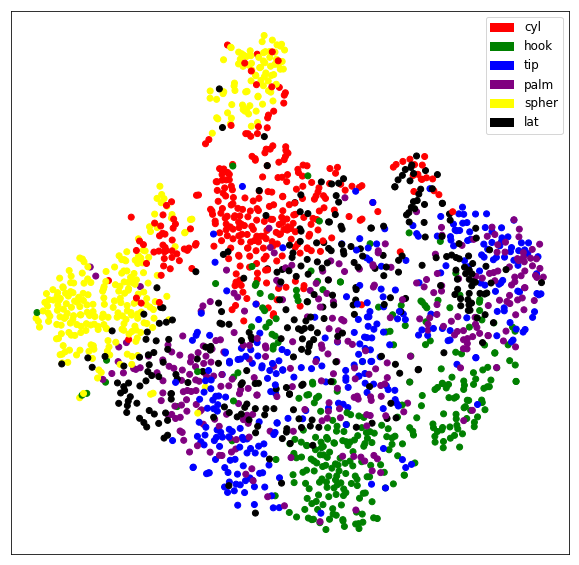

In [8]:
visualization(x,y,num_classes=6,legend=True,method="tsne")

We can use a plot like above for exploratory data analysis. For instance, the movement palm, which correponds to a palmer hand movement, did not seem to cluster that well in the above plot. This could mean that there might something about this movement which makes it hard to detect by the classifer. And as we will see below, the movements which tend to have a poor grouping in the tsne plot above, have a reletively lower accuracy score than other movements. This type of foreshadowing might lead us to go back and try to process the signals more or try better feature engineering. 

Since the features are now extracted, I can call various machine learning models to try classify each signal (now a list of features) as the movement the signal belongs to. In the following code, I call classification_train_test which trains a gradient boosting model using the first two days of recorded signals and then tests the model on the third day which the model has not seen before. 

In [9]:
classification_train_test(x,y, classifier_string = 'grad_boost',dataset_type = "one_subject")

Baseline Random is 16.7%
Accuracy on test set is:  57.99999999999999 %
              precision    recall  f1-score   support

         cyl       0.70      0.76      0.73       100
        hook       0.83      0.58      0.68       100
         lat       0.39      0.82      0.53       100
        palm       0.19      0.10      0.13       100
       spher       0.81      1.00      0.89       100
         tip       0.61      0.22      0.32       100

   micro avg       0.58      0.58      0.58       600
   macro avg       0.59      0.58      0.55       600
weighted avg       0.59      0.58      0.55       600



Below I perform similar analysis than above, but this time I used the dataset which contains five subjects. This allows me to see how well the models would work on people the model hasen't seen before. If the results are much worse, it could be because this signals can be very dependent on the person, even if the movement is the same. However, it should be noted that the five subjects only perform each movement 30 times as opposed to the single subject performing each movement 100 times.

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.22409099340438843 mins


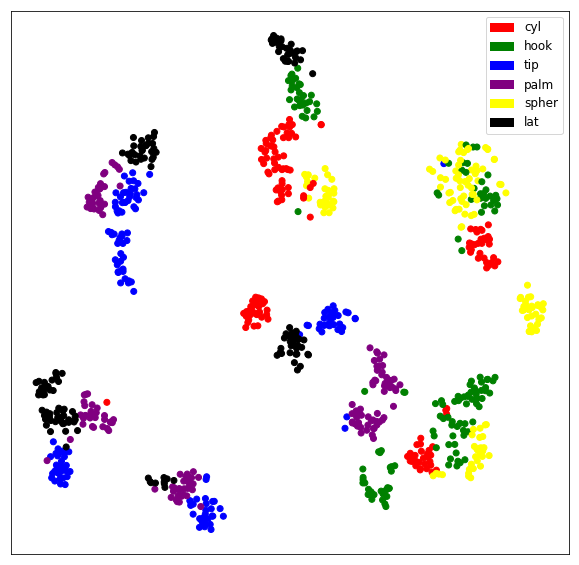

In [11]:
subjects_signals = load_hand_signals_five_subjects() # five subjects repeating each movement 30 times
num_trials = 30
num_sessions = 5 # five subjects

features_signals = feature_extraction(subjects_signals,feature_name_list=['rms_window'],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)

x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)

visualization(x,y,num_classes=6,legend=True,method="tsne")


In [12]:
classification_train_test(x,y, classifier_string = 'random_forest',dataset_type = "five_subjects")

Baseline Random is 16.7%
Accuracy on test set is:  40.0 %
              precision    recall  f1-score   support

         cyl       0.45      0.73      0.56        30
        hook       0.00      0.00      0.00        30
         lat       0.60      0.70      0.65        30
        palm       0.60      0.40      0.48        30
       spher       0.28      0.17      0.21        30
         tip       0.63      0.40      0.49        30

   micro avg       0.40      0.40      0.40       180
   macro avg       0.43      0.40      0.40       180
weighted avg       0.43      0.40      0.40       180



C:\Users\wrobe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


As we can see from the results above, the classifier does not do a great job generalizing to the hold out subject. This could be because there is a lot of variance in the emg signals of different people, perhaps because of the way the electrodes were placed and differences in movements between subjects.